In [5]:
##import the necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from PIL import Image
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
import cv2
import os
from tqdm import tqdm
print('import done')

import done


In [6]:
!ls ../input/planets-dataset/planet/planet

sample_submission.csv  test-jpg  train-jpg  train_classes.csv


In [7]:
path = "../input/planets-dataset/planet/planet/"
train_path = os.path.join(path, "train-jpg")
test_path = os.path.join(path, "test-jpg")
class_path = os.path.join(path, "train_classes.csv")
submission_path = os.path.join(path, "sample_submission.csv")

In [8]:
#reading the labels
df = pd.read_csv(class_path)
submission_df = pd.read_csv(submission_path)

print(df.shape)
print(submission_df.shape)

(40479, 2)
(61191, 2)


In [9]:
label_list = []
for tag_split in df.tags.to_numpy():
    labels = tag_split.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [10]:
print(len(label_list))

17


In [11]:
labels_dict = dict(zip(range(0,17), label_list))
labels_dict

{0: 'haze',
 1: 'primary',
 2: 'agriculture',
 3: 'clear',
 4: 'water',
 5: 'habitation',
 6: 'road',
 7: 'cultivation',
 8: 'slash_burn',
 9: 'cloudy',
 10: 'partly_cloudy',
 11: 'conventional_mine',
 12: 'bare_ground',
 13: 'artisinal_mine',
 14: 'blooming',
 15: 'selective_logging',
 16: 'blow_down'}

In [12]:
# One-hot encode the features
for label in label_list:
    df[label] = df['tags'].apply(lambda x: 1 if label in x.split() else 0)
    
df.head(3)

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


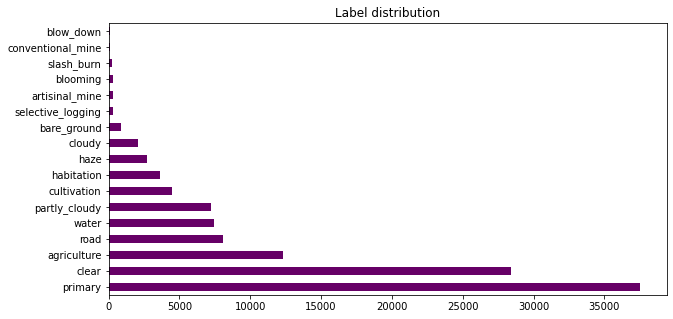

In [13]:
# plot the labels      
df[label_list].sum().sort_values(ascending=False)\
.plot(kind='barh', title='Label distribution', orientation= 'horizontal', figsize=(10, 5), color='#660066')
plt.show()

In [14]:
import gc
gc.collect()

4704

In [15]:
# for the analysis we need columns after tag and image_name
df_columns = list(df.columns[2:])
# print(df_columns,end='')

In [16]:
# Onehot encode the image name
df['image_name'] = df['image_name'].apply(lambda x: f'{x}.jpg')
df.head(3)

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0.jpg,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2.jpg,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
import gc
gc.collect()

69

In [18]:
def f_beta_score(y_true, y_pred, beta = 2, epsilon = 1e-4):
    
    beta_squared = beta**2
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    precision = tp/(tp +fp +epsilon)
    recall = tp/(tp + fn + epsilon)
    
    return (1 + beta_squared) * precision * recall / (beta_squared * precision + recall + epsilon)


In [19]:
def accuracy_score(y_true, y_pred, epsilon = 1e-4):
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)
        
    tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32) * tf.cast(tf.logical_not(y_pred), tf.float32), 
                       axis = 1)
    return (tp + tn)/(tp + tn + fp + fn + epsilon)

In [20]:
import gc
gc.collect()

23

In [21]:
##Split training data to training and validation sets
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

# train_set contains 80 percent of images
train_gen = train_datagen.flow_from_dataframe(dataframe=df,
                                              directory = train_path,  
                                              x_col="image_name", 
                                              y_col=df_columns, 
                                              subset="training", 
                                              batch_size=128,
                                              seed=42, 
                                              shuffle = True, 
                                              class_mode="raw", 
                                              target_size=(128,128))


# val_set contains 20 percent of images 
val_gen = train_datagen.flow_from_dataframe(dataframe=df,
                                            directory = train_path,  
                                            x_col="image_name", 
                                            y_col=df_columns, 
                                            subset="validation", 
                                            batch_size=128,
                                            seed=42, 
                                            shuffle = True, 
                                            class_mode="raw", 
                                            target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [22]:
##Building a sequential feed forward network in keras
def model_building():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(128, 128, 3)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))
    
    return model
    

In [23]:
model = model_building()
model.summary()

2023-01-17 16:23:57.077349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 16:23:57.159193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 16:23:57.160041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        3

2023-01-17 16:23:57.162541: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 16:23:57.162851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 16:23:57.163592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 16:23:57.164288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [24]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[f_beta_score, accuracy_score])

# Save the callback
callback = EarlyStopping(
    monitor="val_loss", 
    patience=2,
    verbose=0,
    baseline=None,
    restore_best_weights=True,
)

In [25]:
# Batchsize for training and validation set
train_steps = train_gen.n // train_gen.batch_size
val_steps = val_gen.n // train_gen.batch_size

In [26]:
import gc
gc.collect()

259

In [27]:
history = model.fit(x=train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10,
                    callbacks=[callback]) 

2023-01-17 16:24:00.743080: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-17 16:24:03.660840: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


253/253 [==============================] - 280s 1s/step - loss: 0.2439 - f_beta_score: 0.6557 - accuracy_score: 0.9062 - val_loss: 0.1995 - val_f_beta_score: 0.6854 - val_accuracy_score: 0.9175
Epoch 2/10
253/253 [==============================] - 105s 415ms/step - loss: 0.1806 - f_beta_score: 0.7462 - accuracy_score: 0.9270 - val_loss: 0.1606 - val_f_beta_score: 0.7663 - val_accuracy_score: 0.9369
Epoch 3/10
253/253 [==============================] - 104s 410ms/step - loss: 0.1614 - f_beta_score: 0.7889 - accuracy_score: 0.9368 - val_loss: 0.1428 - val_f_beta_score: 0.8194 - val_accuracy_score: 0.9434
Epoch 4/10
253/253 [==============================] - 103s 406ms/step - loss: 0.1449 - f_beta_score: 0.8115 - accuracy_score: 0.9426 - val_loss: 0.1343 - val_f_beta_score: 0.8290 - val_accuracy_score: 0.9464
Epoch 5/10
253/253 [==============================] - 103s 405ms/step - loss: 0.1368 - f_beta_score: 0.8253 - accuracy_score: 0.9456 - val_loss: 0.1272 - val_f_beta_score: 0.8335 - v

In [28]:
import gc
gc.collect()

35

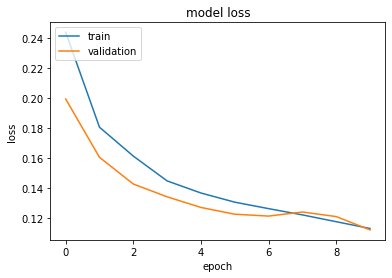

In [29]:
##visualize the images
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [30]:
# Test data: divide the submission dataframe into two splits as the image names after 40669 is different 
test_df = submission_df.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)

In [31]:
test_df['image_name'] = submission_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
test_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [32]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_gen = test_datagen.flow_from_dataframe(dataframe=test_df,
                                            directory = test_path,  
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=67,
                                            shuffle=False,
                                            class_mode=None, 
                                            target_size=(128,128))

test_size = test_gen.n // test_gen.batch_size

Found 40669 validated image filenames.


In [45]:
pred = model.predict(test_gen, steps=test_size, verbose=1)

607/607 [==============================] - 104s 171ms/step


In [46]:
test_names = test_gen.filenames 
        
test_result = pd.DataFrame(pred)
test_result = test_result.apply(lambda x: ' '.join(np.array(label_list)[x >= 0.2]), axis=1)

test_result_df = pd.DataFrame({'image_name': test_names, 'tags': test_result})
test_result_df.head()

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary agriculture partly_cloudy
3,test_3.jpg,primary agriculture clear
4,test_4.jpg,primary partly_cloudy


In [47]:
# additional batch of the test dataset
additional_df = submission_df.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)

In [48]:
additional_df['image_name'] = additional_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
additional_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [49]:
additional_gen = test_datagen.flow_from_dataframe(dataframe=additional_df,
                                                  directory="../input/planets-dataset/test-jpg-additional/test-jpg-additional", 
                                                  x_col='image_name',
                                                  y_col = None,
                                                  batch_size=62,
                                                  shuffle=False,
                                                  class_mode=None, 
                                                  target_size=(128, 128))


additional_step = additional_gen.n // additional_gen.batch_size

Found 20522 validated image filenames.


In [50]:
# predicted probabilities for each class
pred_additional = model.predict(additional_gen, steps=additional_step, verbose=1)

331/331 [==============================] - 52s 156ms/step


In [51]:
additional_names = additional_gen.filenames 
        
additional_result = pd.DataFrame(pred_additional)
additional_result = additional_result.apply(lambda x: ' '.join(np.array(label_list)[x >= 0.2]), axis=1)

additional_result_df = pd.DataFrame({'image_name': additional_names, 'tags': additional_result})
additional_result_df.head()

,image_name,tags
0,file_0.jpg,primary clear
1,file_1.jpg,primary agriculture clear habitation road part...
2,file_10.jpg,haze primary agriculture clear water road
3,file_100.jpg,primary agriculture clear water road
4,file_1000.jpg,primary clear


In [52]:
final_result = pd.concat([test_result_df, additional_result_df])

final_result = final_result.reset_index().drop('index', axis =1)

final_result

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary agriculture partly_cloudy
3,test_3.jpg,primary agriculture clear
4,test_4.jpg,primary partly_cloudy
...,...,...
61186,file_9995.jpg,primary cloudy partly_cloudy
61187,file_9996.jpg,primary agriculture clear water
61188,file_9997.jpg,primary agriculture clear water road
61189,file_9998.jpg,cloudy


In [53]:
# Remove the .jpg extension from the image_name of the final_result
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary agriculture partly_cloudy
3,test_3,primary agriculture clear
4,test_4,primary partly_cloudy
...,...,...
61186,file_9995,primary cloudy partly_cloudy
61187,file_9996,primary agriculture clear water
61188,file_9997,primary agriculture clear water road
61189,file_9998,cloudy


In [55]:
# save the results to a CSV file save and set the index to false.
final_result.to_csv('submission.csv', index=False)